In [1]:
import matplotlib.pyplot as plot
import numpy as np

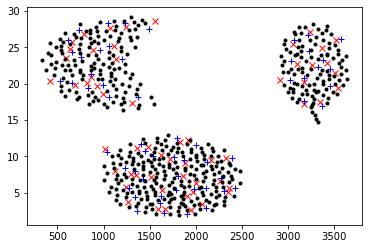

In [2]:
data = np.loadtxt('cluster.dat')

testing = np.array([ item for index, item in enumerate(data) if index % 10 == 0 ])
validation = np.array([ item for index, item in enumerate(data) if index % 10 == 1 ])
training = np.array([ item for index, item in enumerate(data) if index % 10 >= 2 ])

plot.plot(testing[:,0], testing[:,1], 'x', color='red')
plot.plot(validation[:,0], validation[:,1], '+', color='blue')
plot.plot(training[:,0], training[:,1], '.', color='black')
plot.show()

In [ ]:
data = np.loadtxt(